# Assessing line diagnostics for different tube lengths

Need to understand what we're losing by shortening the tube and losing wavelengths

In [145]:
import copy

import astropy.table
import astropy.units as u
import matplotlib.pyplot as plt
from adjustText import adjust_text
import numpy as np
import fiasco
from scipy.interpolate import interp1d
from aiapy.response import Channel

from astropy.visualization import quantity_support

from mocksipipeline.detector.response import SpectrogramChannel

In [3]:
line_list = astropy.table.QTable.read('../data/line_lists/curated_line_list.asdf')

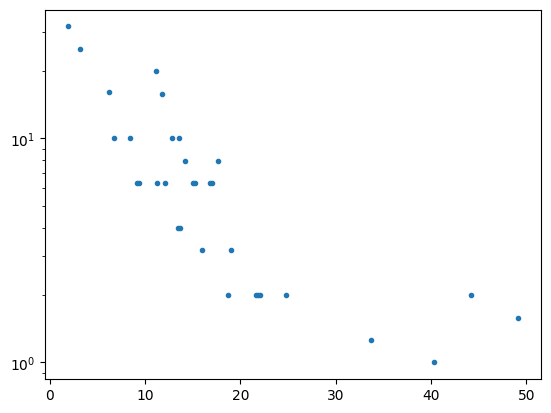

In [8]:
plt.plot(line_list['wavelength'], line_list['T_max (Maxwellian)'].to('MK'),
         marker='.', ls='')
plt.yscale('log')

In [257]:
full_line_list = astropy.table.QTable.read('../data/line_lists/full-line-list.asdf')

In [258]:
channel_o1 = SpectrogramChannel(1)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


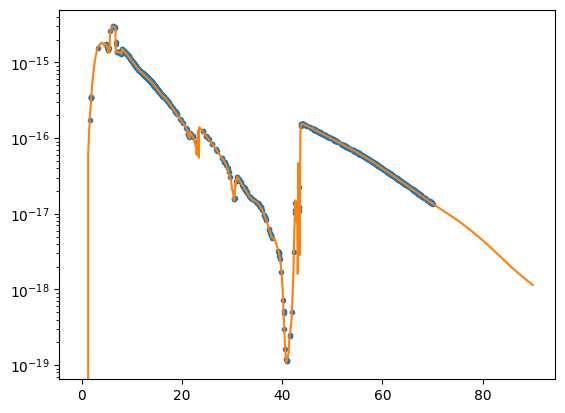

In [259]:
response_unit = u.Unit('cm2 sr / ( pix)')
intensity_unit = response_unit * u.Unit('ph cm-2 s-1 sr-1')
f_interp_ea = interp1d(channel_o1.wavelength.to_value('AA'),
                       (channel_o1.effective_area* channel_o1.plate_scale).to_value(response_unit),
                       bounds_error=True,
                       assume_sorted=False)
plt.plot(full_line_list['wavelength'], f_interp_ea(full_line_list['wavelength'].to_value('AA')), marker='.', ls='')
plt.plot(channel_o1.wavelength, channel_o1.effective_area*channel_o1.plate_scale)
plt.yscale('log')

In [260]:
# Add a T_max column based on the ionization fraction (existing ones depend on the DEM used)
temperature_grid = 10**np.arange(4,8,0.001)*u.K
all_chianti_ions = [fiasco.Ion(i, temperature_grid) for i in fiasco.list_ions(fiasco.defaults['hdf5_dbase_root'])]
ioneq_tmax = {i.ion_name_roman: i.formation_temperature for i in all_chianti_ions}
#full_line_list['T_max (Maxwellian)'] = list(map(lambda x: ioneq_tmax[x], full_line_list['ion name']))
# Add a FIP column
all_chianti_elements = [fiasco.Element(el, 1*u.MK) for el in fiasco.list_elements(fiasco.defaults['hdf5_dbase_root'])]
element_is_low_fip = {el.atomic_symbol: el[0].ip<=10*u.eV for el in all_chianti_elements}
full_line_list['is low FIP'] = list(map(lambda x: element_is_low_fip[x], full_line_list['element']))
# Add a column that expresses the intensity in MOXSI detector units
full_line_list['intensity_moxsi (coronal)_active_region'] = (full_line_list['intensity (coronal)_active_region']
                                                             * f_interp_ea(full_line_list['wavelength'].to_value('AA')) 
                                                             * u.Unit(response_unit)).to(intensity_unit)
full_line_list['intensity_moxsi_scaled (coronal)_active_region'] = full_line_list['intensity_moxsi (coronal)_active_region'] / full_line_list['intensity_moxsi (coronal)_active_region'].max()
full_line_list['intensity_moxsi (coronal)_flare_ext'] = (full_line_list['intensity (coronal)_flare_ext']
                                                         * f_interp_ea(full_line_list['wavelength'].to_value('AA')) 
                                                         * u.Unit(response_unit)).to(intensity_unit)
full_line_list['intensity_moxsi_scaled (coronal)_flare_ext'] = full_line_list['intensity_moxsi (coronal)_flare_ext'] / full_line_list['intensity_moxsi (coronal)_flare_ext'].max()

In [263]:
full_line_list.colnames

['atomic number',
 'ionization stage',
 'transition',
 'transition (latex)',
 'ion name',
 'lower level',
 'upper level',
 'max temperature_flare_ext',
 'wavelength',
 'only theoretical_flare_ext',
 'element',
 'ion id',
 'energy',
 'abundance (coronal)',
 'abundance (photospheric)',
 'intensity (coronal)_flare_ext',
 'intensity_scaled (coronal)_flare_ext',
 'intensity (photospheric)_flare_ext',
 'intensity_scaled (photospheric)_flare_ext',
 'max temperature_active_region',
 'only theoretical_active_region',
 'intensity (coronal)_active_region',
 'intensity_scaled (coronal)_active_region',
 'intensity (photospheric)_active_region',
 'intensity_scaled (photospheric)_active_region',
 'is low FIP',
 'intensity_moxsi (coronal)_active_region',
 'intensity_moxsi_scaled (coronal)_active_region',
 'intensity_moxsi (coronal)_flare_ext',
 'intensity_moxsi_scaled (coronal)_flare_ext']

Text(192.09722222222223, 0.5, 'Effective Formation Temperature ($\\argmax_T G(T)\\mathrm{DEM}(T)$) [MK]')

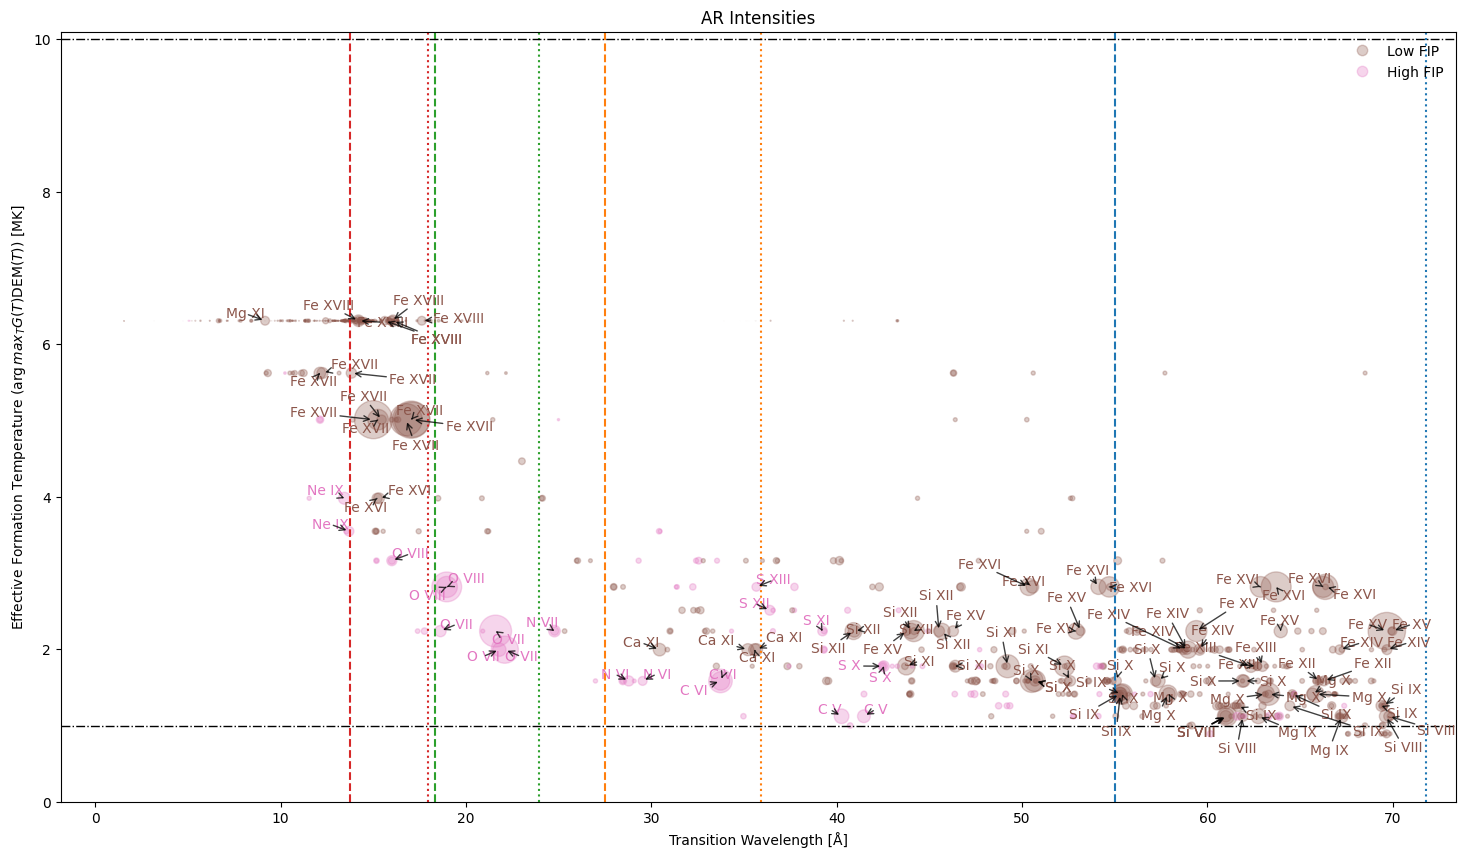

In [315]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
low_fip_color = 'C5'
high_fip_color = 'C6'
with quantity_support():
    ax.scatter(full_line_list['wavelength'],
               full_line_list['max temperature_active_region'].to('MK'),
               s=full_line_list['intensity_scaled (coronal)_active_region']*3e3,
               marker='.', alpha=0.3, color=[low_fip_color if r['is low FIP'] else high_fip_color for r in full_line_list])
    for ls,spec_res in zip(['--', ':'], [55, 71.8] * u.milliAA / u.pix):
        max_wave = 1000 * u.pix * spec_res
        for i,order in enumerate([1,2,3,4]):
            ax.axvline(x=max_wave/order, ls=ls, color=f'C{i}')
    ax.axhline(y=1*u.MK, ls='-.', color='k', lw=1)
    ax.axhline(y=10*u.MK, ls='-.', color='k', lw=1)
    
    line_labels = []
    line_label_tol = 0.05
    for row in full_line_list:
        if row['intensity_scaled (coronal)_active_region'] >= line_label_tol:
            line_labels.append(ax.text(row['wavelength'], row['max temperature_active_region'], row['ion name'],
                                       color=low_fip_color if row['is low FIP'] else high_fip_color))
    adjust_text(
        line_labels,
        x=copy.deepcopy(full_line_list['wavelength'].to_value('AA')),
        y=copy.deepcopy(full_line_list['max temperature_active_region'].to_value('MK')),
        avoid_points=False,
        arrowprops=dict(arrowstyle='->', color='k', alpha=0.75),
    )
    #ax.set_yscale('log')
    ax.set_ylim(0,10.1)
    ax.set_title('AR Intensities')
    ax.legend(handles=[plt.Line2D([0], [0], marker='.', color=low_fip_color, label='Low FIP', ls='', alpha=0.3, markersize=15),
                       plt.Line2D([0], [0], marker='.', color=high_fip_color, label='High FIP', ls='', alpha=0.3, markersize=15)],
              loc=1, frameon=False)
ax.set_xlabel(r'Transition Wavelength [Å]')
ax.set_ylabel(r'Effective Formation Temperature ($\argmax_T G(T)\mathrm{DEM}(T)$) [MK]')

Text(192.09722222222223, 0.5, 'Effective Formation Temperature ($\\argmax_T G(T)\\mathrm{DEM}(T)$) [MK]')

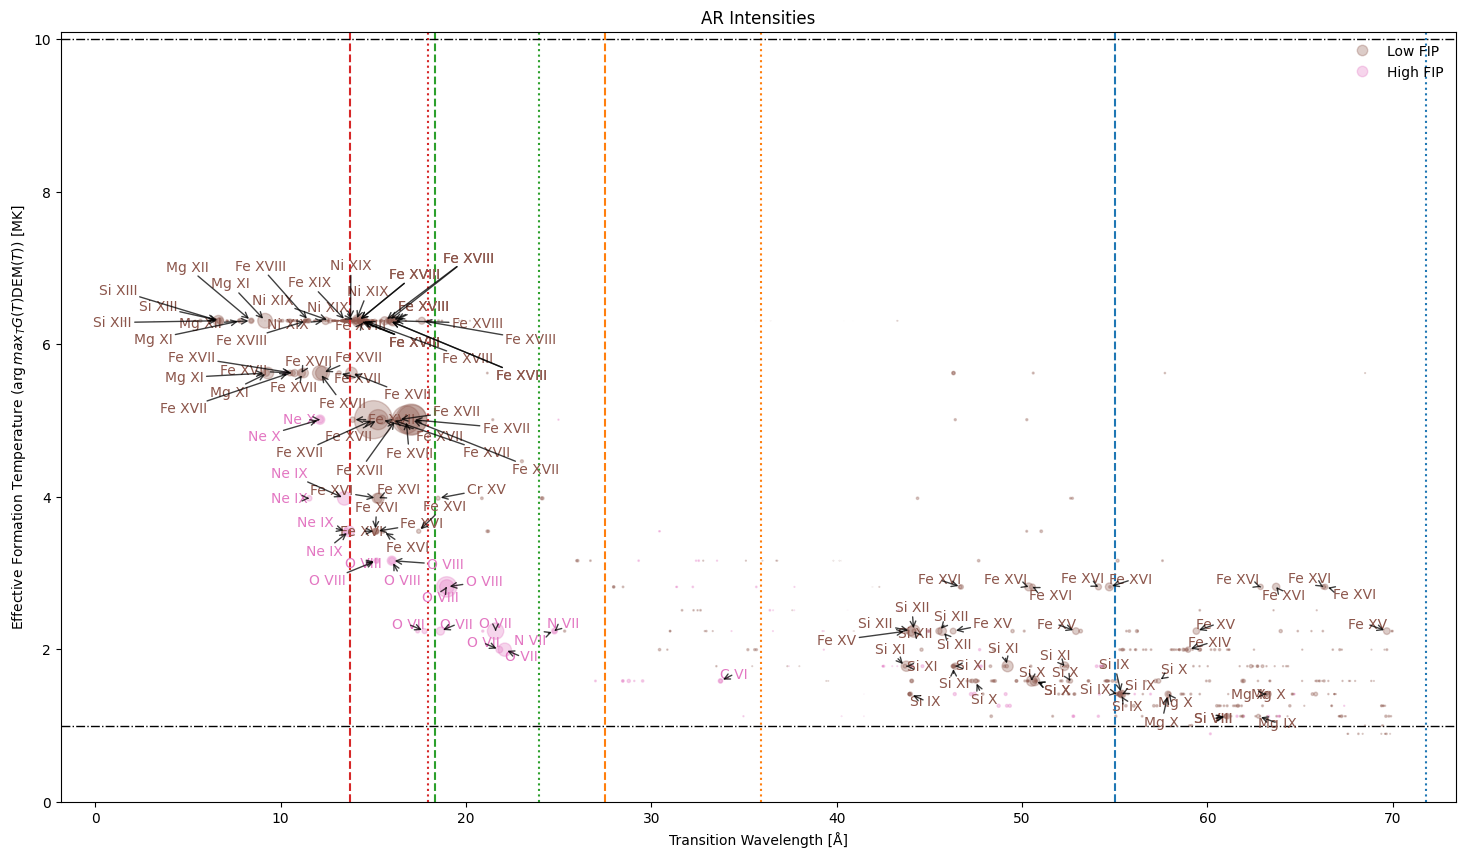

In [319]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
low_fip_color = 'C5'
high_fip_color = 'C6'
with quantity_support():
    ax.scatter(full_line_list['wavelength'],
               full_line_list['max temperature_active_region'].to('MK'),
               s=full_line_list['intensity_moxsi_scaled (coronal)_active_region']*3e3,
               marker='.', alpha=0.3, color=[low_fip_color if r['is low FIP'] else high_fip_color for r in full_line_list])
    for ls,spec_res in zip(['--', ':'], [55, 71.8] * u.milliAA / u.pix):
        max_wave = 1000 * u.pix * spec_res
        for i,order in enumerate([1,2,3,4]):
            ax.axvline(x=max_wave/order, ls=ls, color=f'C{i}')
    ax.axhline(y=1*u.MK, ls='-.', color='k', lw=1)
    ax.axhline(y=10*u.MK, ls='-.', color='k', lw=1)
    
    line_labels = []
    line_label_tol = 0.01
    for row in full_line_list:
        if row['intensity_moxsi_scaled (coronal)_active_region'] >= line_label_tol:
            line_labels.append(ax.text(row['wavelength'], row['max temperature_active_region'], row['ion name'],
                                       color=low_fip_color if row['is low FIP'] else high_fip_color))
    adjust_text(
        line_labels,
        x=copy.deepcopy(full_line_list['wavelength'].to_value('AA')),
        y=copy.deepcopy(full_line_list['max temperature_active_region'].to_value('MK')),
        avoid_points=False,
        arrowprops=dict(arrowstyle='->', color='k', alpha=0.75),
    )
    #ax.set_yscale('log')
    ax.set_ylim(0,10.1)
    ax.set_title('AR Intensities')
    ax.legend(handles=[plt.Line2D([0], [0], marker='.', color=low_fip_color, label='Low FIP', ls='', alpha=0.3, markersize=15),
                       plt.Line2D([0], [0], marker='.', color=high_fip_color, label='High FIP', ls='', alpha=0.3, markersize=15)],
              loc=1, frameon=False)
ax.set_xlabel(r'Transition Wavelength [Å]')
ax.set_ylabel(r'Effective Formation Temperature ($\argmax_T G(T)\mathrm{DEM}(T)$) [MK]')

Text(192.09722222222223, 0.5, 'Effective Formation Temperature ($\\argmax_T G(T)\\mathrm{DEM}(T)$) [MK]')

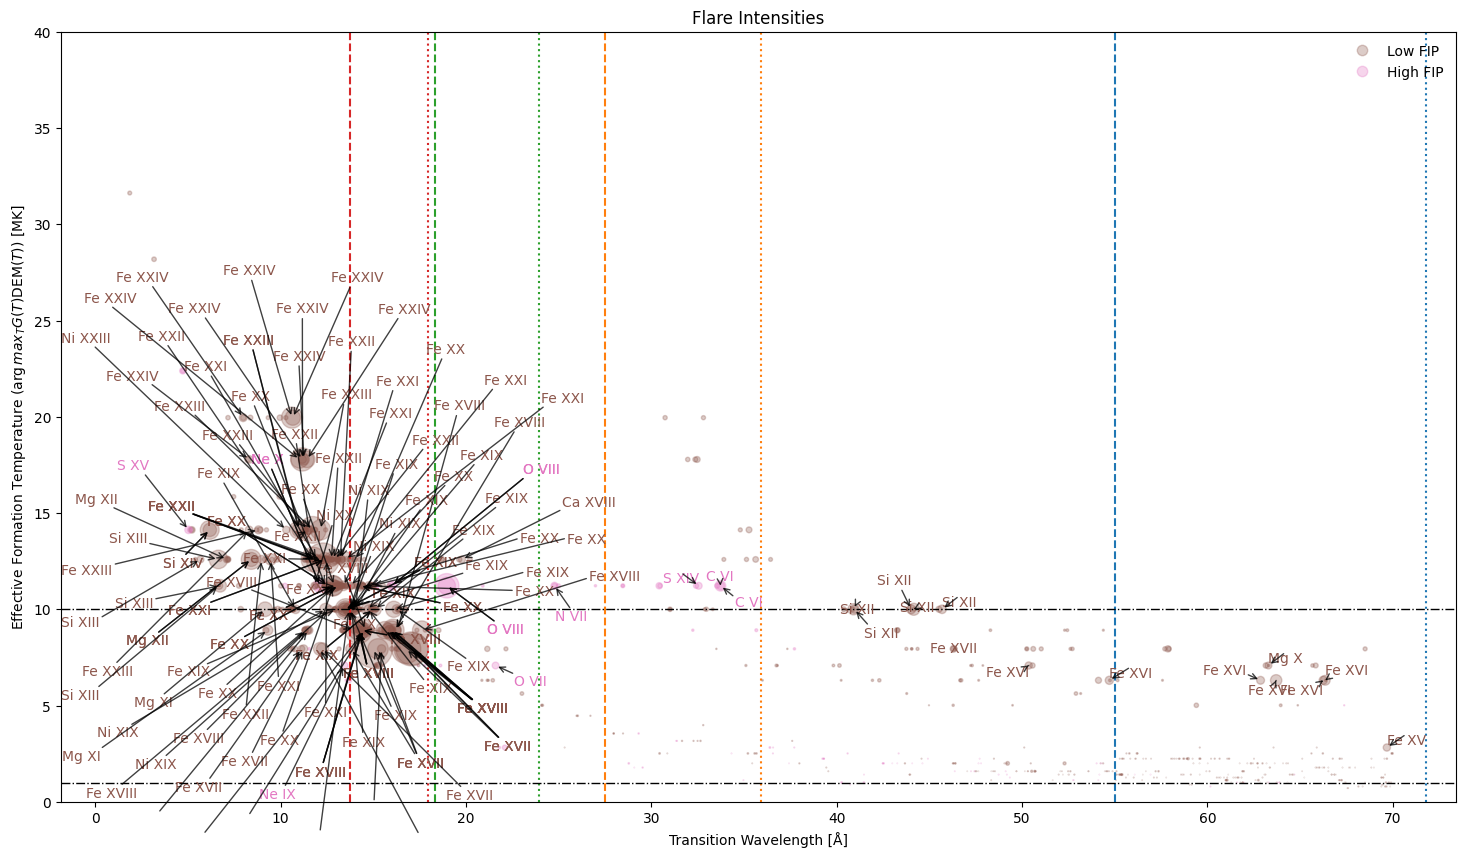

In [321]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
with quantity_support():
    ax.scatter(full_line_list['wavelength'],
               full_line_list['max temperature_flare_ext'].to('MK'),
               s=full_line_list['intensity_scaled (coronal)_flare_ext']*3e3,
               marker='.', alpha=0.3, color=[low_fip_color if r['is low FIP'] else high_fip_color for r in full_line_list])
    for ls,spec_res in zip(['--', ':'], [55, 71.8] * u.milliAA / u.pix):
        max_wave = 1000 * u.pix * spec_res
        for i,order in enumerate([1,2,3,4]):
            ax.axvline(x=max_wave/order, ls=ls, color=f'C{i}')
    ax.axhline(y=1*u.MK, ls='-.', color='k', lw=1)
    ax.axhline(y=10*u.MK, ls='-.', color='k', lw=1)
    
    line_labels = []
    line_label_tol = 0.03
    for row in full_line_list:
        if row['intensity_scaled (coronal)_flare_ext'] >= line_label_tol:
            line_labels.append(ax.text(row['wavelength'], row['max temperature_flare_ext'], row['ion name'],
                                       color=low_fip_color if row['is low FIP'] else high_fip_color,clip_on=True))
    adjust_text(
        line_labels,
        x=copy.deepcopy(full_line_list['wavelength'].to_value('AA')),
        y=copy.deepcopy(full_line_list['max temperature_flare_ext'].to_value('MK')),
        avoid_points=False,
        arrowprops=dict(arrowstyle='->', color='k', alpha=0.75),
        clip_on=True,
    )
    #ax.set_yscale('log')
    ax.set_ylim(0,40)
    ax.set_title('Flare Intensities')
    ax.legend(handles=[plt.Line2D([0], [0], marker='.', color=low_fip_color, label='Low FIP', ls='', alpha=0.3, markersize=15),
                   plt.Line2D([0], [0], marker='.', color=high_fip_color, label='High FIP', ls='', alpha=0.3, markersize=15)],
          loc=1, frameon=False)
ax.set_xlabel(r'Transition Wavelength [Å]')
ax.set_ylabel(r'Effective Formation Temperature ($\argmax_T G(T)\mathrm{DEM}(T)$) [MK]')

Text(192.09722222222223, 0.5, 'Effective Formation Temperature ($\\argmax_T G(T)\\mathrm{DEM}(T)$) [MK]')

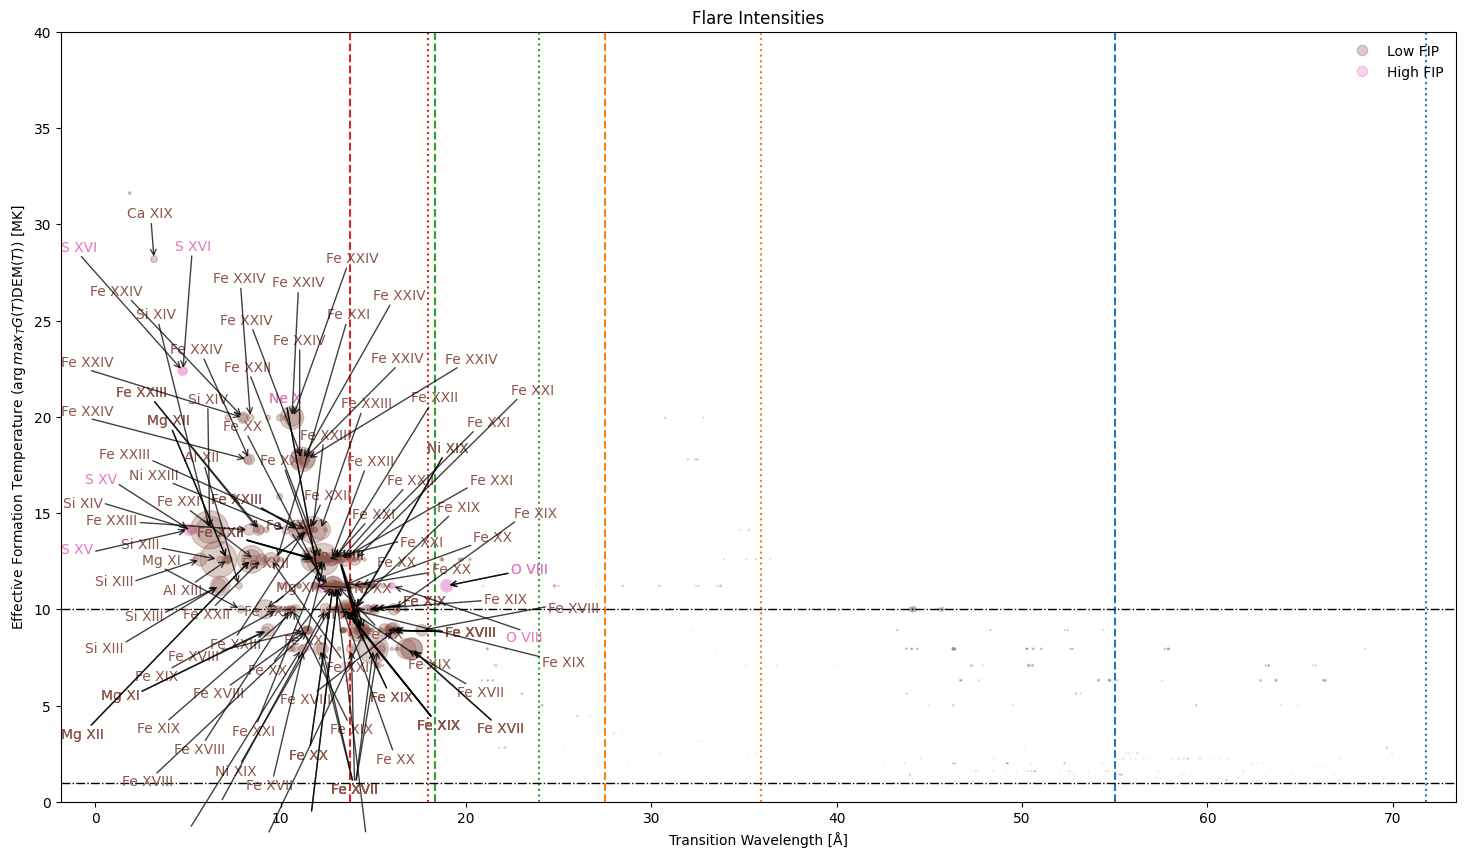

In [320]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
with quantity_support():
    ax.scatter(full_line_list['wavelength'],
               full_line_list['max temperature_flare_ext'].to('MK'),
               s=full_line_list['intensity_moxsi_scaled (coronal)_flare_ext']*3e3,
               marker='.', alpha=0.3, color=[low_fip_color if r['is low FIP'] else high_fip_color for r in full_line_list])
    for ls,spec_res in zip(['--', ':'], [55, 71.8] * u.milliAA / u.pix):
        max_wave = 1000 * u.pix * spec_res
        for i,order in enumerate([1,2,3,4]):
            ax.axvline(x=max_wave/order, ls=ls, color=f'C{i}')
    ax.axhline(y=1*u.MK, ls='-.', color='k', lw=1)
    ax.axhline(y=10*u.MK, ls='-.', color='k', lw=1)
    
    line_labels = []
    line_label_tol = 0.03
    for row in full_line_list:
        if row['intensity_moxsi_scaled (coronal)_flare_ext'] >= line_label_tol:
            line_labels.append(ax.text(row['wavelength'], row['max temperature_flare_ext'], row['ion name'],
                                       color=low_fip_color if row['is low FIP'] else high_fip_color,
                                       clip_on=True))
    adjust_text(
        line_labels,
        x=copy.deepcopy(full_line_list['wavelength'].to_value('AA')),
        y=copy.deepcopy(full_line_list['max temperature_flare_ext'].to_value('MK')),
        avoid_points=False,
        arrowprops=dict(arrowstyle='->', color='k', alpha=0.75),
        clip_on=True,
    )
    #ax.set_yscale('log')
    ax.set_ylim(0,40)
    ax.set_title('Flare Intensities')
    ax.legend(handles=[plt.Line2D([0], [0], marker='.', color=low_fip_color, label='Low FIP', ls='', alpha=0.3, markersize=15),
                   plt.Line2D([0], [0], marker='.', color=high_fip_color, label='High FIP', ls='', alpha=0.3, markersize=15)],
          loc=1, frameon=False)
ax.set_xlabel(r'Transition Wavelength [Å]')
ax.set_ylabel(r'Effective Formation Temperature ($\argmax_T G(T)\mathrm{DEM}(T)$) [MK]')

In [211]:
full_line_list[full_line_list['ion name']=='Ca XIX']

atomic number,ionization stage,transition,transition (latex),ion name,lower level,upper level,max temperature_flare_ext,wavelength,only theoretical_flare_ext,element,ion id,energy,abundance (coronal),abundance (photospheric),intensity (coronal)_flare_ext,intensity_scaled (coronal)_flare_ext,intensity (photospheric)_flare_ext,intensity_scaled (photospheric)_flare_ext,max temperature_active_region,only theoretical_active_region,intensity (coronal)_active_region,intensity_scaled (coronal)_active_region,intensity (photospheric)_active_region,intensity_scaled (photospheric)_active_region,T_max (Maxwellian),is low FIP,intensity_moxsi (coronal)_active_region,intensity_moxsi (coronal)_flare_ext,intensity_moxsi_scaled (coronal)_active_region,intensity_moxsi_scaled (coronal)_flare_ext
,,,,,,,MK,Angstrom,,,,keV,,,ph / (cm2 s sr),,ph / (cm2 s sr),,MK,,ph / (cm2 s sr),,ph / (cm2 s sr),,K,,ph / (pix s),ph / (pix s),,
int16,int16,str48,str93,str9,int16,int16,float32,float64,bool,str2,str5,float64,float64,float64,float64,float64,float64,float64,float32,bool,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64
20,19,1s2 1S0 - 1s.2p 1P1,1s$^{2}$ $^1$S$_{0}$ - 1s 2p $^1$P$_{1}$,Ca XIX,1,7,28.183815002441406,3.177299976348877,False,Ca,ca_19,3.9021873715453803,8.51138038202376e-06,2.0892961308540407e-06,53168349084686.875,0.014185118905457011,13051282053043.504,0.013386629967561294,6.309576034545898,False,2745900.319859861,1.2336774759948343e-06,674038.5996742386,6.803072194777514e-07,14125375.446261758,True,4.302436112725481e-09,0.08330725755100468,4.346543031098956e-06,0.03003118618894085


In [212]:
ca19 = fiasco.Ion('Ca XIX', np.logspace(5,8,1000)*u.K)

In [213]:
goft_ca19 = ca19.contribution_function(1e15*u.Unit('cm-3 K')/ca19.temperature, couple_density_to_temperature=True,)

In [218]:
transitions_ca19 = ca19.transitions.wavelength[~ca19.transitions.is_twophoton]
idx = np.argmin(np.fabs(transitions_ca19-3.177299976348877*u.AA))
transitions_ca19[idx]
goft_ca19_ = goft_ca19.squeeze()[:,idx]

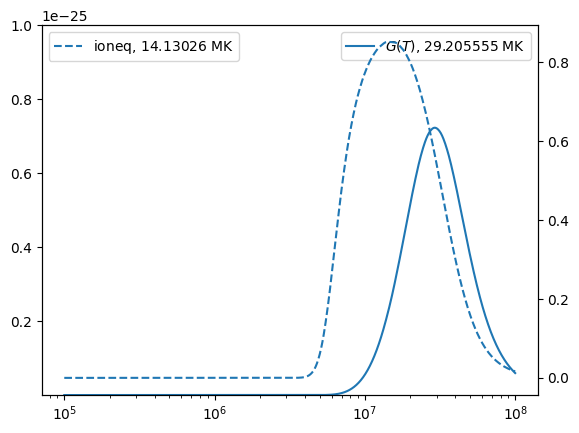

In [306]:
plt.plot(ca19.temperature, goft_ca19_, color='C0', ls='-', label=f'$G(T)$, {ca19.temperature[np.argmax(goft_ca19_)].to("MK"):latex}')
plt.xscale('log')
plt.ylim(1e-28, 1e-25)
plt.legend(loc=1)
plt.twinx().plot(ca19.temperature, ca19.ioneq, color='C0', ls='--', label=f'ioneq, {ca19.temperature[np.argmax(ca19.ioneq)].to("MK"):latex}')
plt.legend(loc=2)

In [274]:
oxygen = fiasco.Element('oxygen', 10**np.arange(5,8,0.05)*u.K)

In [280]:
def find_goft(goft, ion, transition):
    transitions_ion = ion.transitions.wavelength[~ion.transitions.is_twophoton]
    idx = np.argmin(np.fabs(transitions_ion-transition))
    print(transitions_ion[idx])
    return goft[..., idx].squeeze()

In [302]:
o7_goft = oxygen[6].contribution_function(1e15*u.Unit('cm-3 K')/oxygen.temperature, couple_density_to_temperature=True)
o8_goft = oxygen[7].contribution_function(1e15*u.Unit('cm-3 K')/oxygen.temperature, couple_density_to_temperature=True)

In [289]:
full_line_list[full_line_list['ion name']=='O VIII']

atomic number,ionization stage,transition,transition (latex),ion name,lower level,upper level,max temperature_flare_ext,wavelength,only theoretical_flare_ext,element,ion id,energy,abundance (coronal),abundance (photospheric),intensity (coronal)_flare_ext,intensity_scaled (coronal)_flare_ext,intensity (photospheric)_flare_ext,intensity_scaled (photospheric)_flare_ext,max temperature_active_region,only theoretical_active_region,intensity (coronal)_active_region,intensity_scaled (coronal)_active_region,intensity (photospheric)_active_region,intensity_scaled (photospheric)_active_region,is low FIP,intensity_moxsi (coronal)_active_region,intensity_moxsi_scaled (coronal)_active_region,intensity_moxsi (coronal)_flare_ext,intensity_moxsi_scaled (coronal)_flare_ext
,,,,,,,MK,Angstrom,,,,keV,,,ph / (cm2 s sr),,ph / (cm2 s sr),,MK,,ph / (cm2 s sr),,ph / (cm2 s sr),,,ph / (pix s),,ph / (pix s),
int16,int16,str48,str93,str9,int16,int16,float32,float64,bool,str2,str5,float64,float64,float64,float64,float64,float64,float64,float32,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64
8,8,1s 2S1/2 - 2p 2P1/2,1s $^2$S$_{1/2}$ - 2p $^2$P$_{1/2}$,O VIII,1,3,11.220189094543457,18.97249984741211,False,O,o_8,0.653494265017016,0.0007762471166286928,0.0004897788193684457,772339483192452.5,0.20605731780412825,487313269352313.5,0.49983460541186453,2.8183817863464355,False,683780940424.323,0.30720894659391895,431436606376.299,0.4354490057492695,False,0.00014096995881062046,0.14241512854782623,0.1592274055867835,0.05739941517857621
8,8,1s 2S1/2 - 2p 2P3/2,1s $^2$S$_{1/2}$ - 2p $^2$P$_{3/2}$,O VIII,1,4,11.220189094543457,18.967100143432617,False,O,o_8,0.6536803069294171,0.0007762471166286928,0.0004897788193684457,1545190098544784.8,0.4122510037782132,974949041294903.1,1.0,2.8183817863464355,False,1367396974302.184,0.6143438040118606,862769163755.955,0.8707929948368375,False,0.00028228267114785877,0.2851765243994479,0.31898592482335897,0.11499028994150647
8,8,1s 2S1/2 - 3p 2P1/2,1s $^2$S$_{1/2}$ - 3p $^2$P$_{1/2}$,O VIII,1,6,11.220189094543457,16.00670051574707,False,O,o_8,0.7745768611790237,0.0007762471166286928,0.0004897788193684457,113454244281620.1,0.030269172791130783,71584788691937.98,0.07342413363149816,3.1622776985168457,False,78278500171.29291,0.035168946890581365,49390394597.97121,0.04984972972481674,False,2.880854027016425e-05,0.029103874332277763,0.04175413629612112,0.015051824752477452
8,8,1s 2S1/2 - 3p 2P3/2,1s $^2$S$_{1/2}$ - 3p $^2$P$_{3/2}$,O VIII,1,7,11.220189094543457,16.00550079345703,False,O,o_8,0.7746349210384242,0.0007762471166286928,0.0004897788193684457,227110775978951.75,0.060592315116662104,143297212114515.1,0.14697918152131448,3.1622776985168457,False,156698404883.3319,0.07040142398131609,98870009429.46901,0.09978950943938328,False,5.7680372436712774e-05,0.058271689405090976,0.0835990267585054,0.030136365205178293
8,8,1s 2S1/2 - 4p 2P1/2,1s $^2$S$_{1/2}$ - 4p $^2$P$_{1/2}$,O VIII,1,11,11.220189094543457,15.17650032043457,False,O,o_8,0.8169485442322979,0.0007762471166286928,0.0004897788193684457,37664510565143.836,0.010048752125656746,23764699567329.277,0.02437532482289084,3.1622776985168457,False,23792132596.086845,0.010689323963213943,15011820802.347567,0.01515143209050504,False,1.0242225696430012e-05,0.010347225050498043,0.016214116847063312,0.005844978891848404
8,8,1s 2S1/2 - 4p 2P3/2,1s $^2$S$_{1/2}$ - 4p $^2$P$_{3/2}$,O VIII,1,12,11.220189094543457,15.175999641418457,False,O,o_8,0.8169754965914837,0.0007762471166286928,0.0004897788193684457,75380739473064.5,0.02011130251389851,47562031202877.94,0.04878412018304795,3.1622776985168457,False,47607003729.86992,0.021388863891512275,30037988652.057304,0.030317344657207427,False,2.0496133877963747e-05,0.02070625235043875,0.032453496481872755,0.011699064691123105


21.602 Angstrom
18.9671 Angstrom


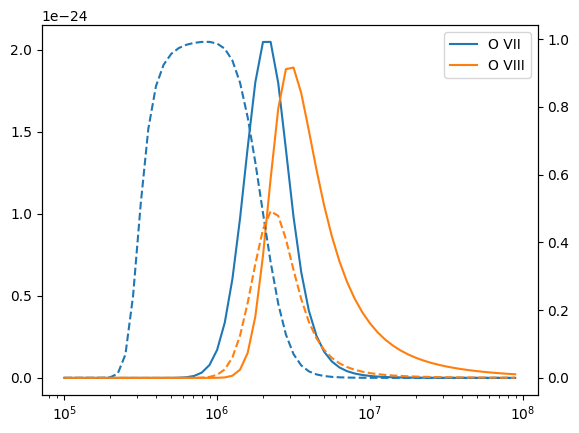

In [303]:
fig = plt.figure()
ax = fig.add_subplot()
ax2 = ax.twinx()
ax.plot(oxygen.temperature, find_goft(o7_goft, oxygen[6], 21.601499557495117*u.AA), color='C0', ls='-', label=oxygen[6].ion_name_roman)
ax2.plot(oxygen.temperature, oxygen[6].ioneq, color='C0', ls='--')
ax.plot(oxygen.temperature, find_goft(o8_goft, oxygen[7], 18.967100143432617*u.AA), color='C1', ls='-', label=oxygen[7].ion_name_roman)
ax2.plot(oxygen.temperature, oxygen[7].ioneq, color='C1', ls='--')
ax.set_xscale('log')
ax.legend()

In [309]:
np.unique(full_line_list['ion name']).shape

(83,)

In [312]:
len(fiasco.list_ions(fiasco.defaults['hdf5_dbase_root']))

495